In [15]:
import kagglehub
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import torch
from numpy.ma.core import concatenate
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import torch.cuda.amp as amp
import numpy as np

In [2]:
"""
# Download latest version
dataset_root = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", dataset_root)
"""
dataset_root = r"C:\Users\yuval\.cache\kagglehub\datasets\mateuszbuda\lgg-mri-segmentation\versions\2\kaggle_3m"

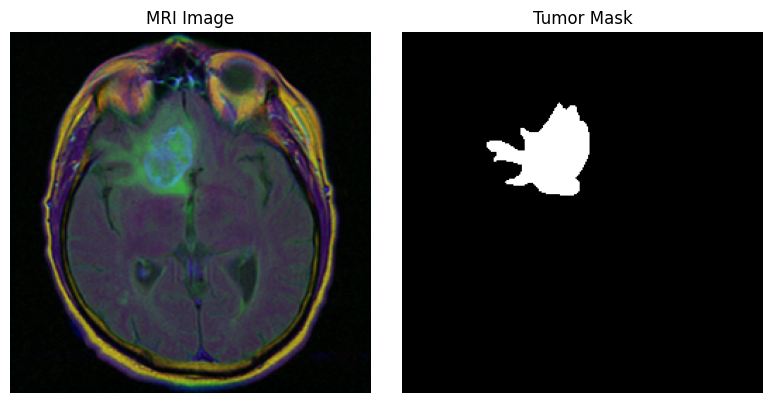

In [3]:
mri_img = Image.open(fr"{dataset_root}\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12.tif")
tumor_map = Image.open(fr"{dataset_root}\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12_mask.tif")
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(mri_img, cmap="gray")
axes[0].set_title("MRI Image")
axes[0].axis("off")

axes[1].imshow(tumor_map, cmap="gray")
axes[1].set_title("Tumor Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True), # inplace=True saves memory
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(1, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512) # New level for 32x32 resolution
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.enc1(x)               # 256
        x2 = self.enc2(self.pool(x1))  # 128
        x3 = self.enc3(self.pool(x2))  # 64
        x4 = self.enc4(self.pool(x3))  # 32
        return x1, x2, x3, x4

class TransformerBottleneck(nn.Module):
    def __init__(self, dim, num_heads=8, num_layers=4, spatial_res=32):
        super().__init__()
        # 32x32 = 1024 tokens (16x faster than 64x64)
        self.pos_embed = nn.Parameter(torch.zeros(1, spatial_res**2, dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=num_heads,
            batch_first=True,
            dropout=0.1,
            activation='gelu' # GELU is standard for Transformers
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        x = self.transformer(x)
        x = x.transpose(1, 2).view(B, C, H, W)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Up 32 -> 64
        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv1 = ConvBlock(512, 256)

        # Up 64 -> 128
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = ConvBlock(256, 128)

        # Up 128 -> 256
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = ConvBlock(128, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, bottleneck_out, x3, x2, x1):
        x = self.up1(bottleneck_out)
        x = torch.cat([x, x3], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv3(x)

        return self.out(x)

class TumorDetector(nn.Module):
    def __init__(self, img_size=256):
        super().__init__()
        self.encoder = Encoder()
        # Resolve to 32x32 for better speed/performance balance
        self.transformer = TransformerBottleneck(dim=512, spatial_res=img_size // 8)
        self.decoder = Decoder()

    def forward(self, x):
        x1, x2, x3, x4 = self.encoder(x)
        bottleneck_out = self.transformer(x4)
        mask_logits = self.decoder(bottleneck_out, x3, x2, x1)
        return mask_logits

In [5]:
class MRIDataset(Dataset):
    def __init__(self, root_dir, limit=20, img_size=256):
        self.samples = []
        self.img_size = img_size

        # Use Interpolation Mode NEAREST for masks to avoid creating "blurry"
        # pixels between 0 and 1 during resizing.
        self.transform_img = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
        ])

        self.transform_mask = T.Compose([
            T.Resize((img_size, img_size), interpolation=T.InterpolationMode.NEAREST),
            T.ToTensor(),
        ])

        i = 0
        # Iterate through patient folders
        for patient in os.listdir(root_dir):
            if limit and i >= limit:
                break
            patient_dir = os.path.join(root_dir, patient)

            if not os.path.isdir(patient_dir):
                continue

            # Find all images and pair them with their masks
            for fname in os.listdir(patient_dir):
                if fname.endswith(".tif") and not fname.endswith("_mask.tif"):
                    img_path = os.path.join(patient_dir, fname)
                    mask_path = img_path.replace(".tif", "_mask.tif")

                    if os.path.exists(mask_path):
                        self.samples.append((img_path, mask_path))
            i += 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        # 1. Load as Grayscale ('L')
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # 2. Apply transforms
        image = self.transform_img(image)
        mask = self.transform_mask(mask)

        # 3. Ensure mask is strictly binary (0.0 or 1.0)
        # We use a threshold because T.ToTensor() scales pixels to [0, 1]
        mask = (mask > 0.1).float()

        return image, mask

In [6]:


# Load dataset (e.g., just first patient for testing)
dataset = MRIDataset(dataset_root, limit=30)

# Split: 80% train, 20% validation
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,      # You can likely increase this now
    shuffle=True,
    num_workers=0,       # Set to number of CPU cores
    pin_memory=True      # Speeds up transfer to GPU
)
val_loader = DataLoader(val_dataset, batch_size=16,      # You can likely increase this now
    shuffle=True,
    num_workers=0,       # Set to number of CPU cores
    pin_memory=True)      # Speeds up transfer to GPU)


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = TumorDetector().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)


cuda


In [8]:
def soft_dice(probs, targets, eps=1e-6):
    # Uses raw probabilities [0, 1]
    intersection = (probs * targets).sum()
    union = probs.sum() + targets.sum()
    return (2 * intersection + eps) / (union + eps)

def hard_dice(preds_bin, targets, eps=1e-6):
    # Uses binary thresholded values {0, 1}
    intersection = (preds_bin * targets).sum()
    union = preds_bin.sum() + targets.sum()
    return (2 * intersection + eps) / (union + eps)

def get_metrics(outputs, targets):
    probs = torch.sigmoid(outputs)
    preds_bin = (probs > 0.5).float()

    # Pass probs to soft, and binary to hard
    s_dice = soft_dice(probs, targets)
    h_dice = hard_dice(preds_bin, targets)

    return s_dice.item(), h_dice.item()

def dice_loss(outputs, targets, eps=1e-6):
    # 1. Convert logits to probabilities
    probs = torch.sigmoid(outputs)

    # 2. Calculate intersection and union over spatial dimensions (H, W)
    # dim=(1,2,3) assumes shape is (Batch, Channel, Height, Width)
    intersection = (probs * targets).sum(dim=(1, 2, 3))
    union = probs.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))

    # 3. Calculate Dice score per image in batch
    dice = (2. * intersection + eps) / (union + eps)

    # 4. Return Loss as 1 - average Dice
    return 1. - dice.mean()

In [9]:
# 1. Initialize Scaler for Mixed Precision
scaler = amp.GradScaler()

num_epochs = 30

for epoch in range(num_epochs):
    # --- TRAINING ---
    model.train()
    train_loss, train_h_dice = 0, 0

    # Use tqdm to see real-time progress per batch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        # 2. Autocast context for faster Transformer math
        with amp.autocast():
            outputs = model(images)
            # Weighted Loss: 80% Dice / 20% BCE
            loss = (0.8 * dice_loss(outputs, masks)) + (0.2 * criterion(outputs, masks))

        # 3. Scaled Backward Pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, h_dice = get_metrics(outputs, masks)
        train_loss += loss.item()
        train_h_dice += h_dice

        # Update progress bar text
        pbar.set_postfix({"loss": f"{loss.item():.4f}", "dice": f"{h_dice:.4f}"})

    # --- VALIDATION ---
    model.eval()
    val_h_dice, max_p = 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            # Use autocast here too for speed
            with amp.autocast():
                outputs = model(images)

            _, h_dice = get_metrics(outputs, masks)
            val_h_dice += h_dice
            max_p = max(max_p, torch.sigmoid(outputs).max().item())

    avg_val_dice = val_h_dice / len(val_loader)

    # --- SCHEDULER STEP ---
    # Maximize Val Dice
    scheduler.step(avg_val_dice)

    # --- LOGGING ---
    print(f"\nSummary Epoch [{epoch+1}/{num_epochs}] "
          f"Avg Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Dice: {avg_val_dice:.4f} | "
          f"Max Prob: {max_p:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 30)

C:\Users\yuval\AppData\Local\Temp\ipykernel_15660\3772323667.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1/30 [Train]:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\yuval\AppData\Local\Temp\ipykernel_15660\3772323667.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1/30 [Train]: 100%|██████████| 50/50 [01:52<00:00,  2.24s/it, loss=0.8690, dice=0.1552]
C:\Users\yuval\AppData\Local\Temp\ipykernel_15660\3772323667.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Summary Epoch [1/30] Avg Loss: 0.8731 | Val Dice: 0.1598 | Max Prob: 0.9990 | LR: 0.000100
------------------------------


Epoch 2/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.8122, dice=0.4089]



Summary Epoch [2/30] Avg Loss: 0.8418 | Val Dice: 0.1827 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 3/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.92s/it, loss=0.8512, dice=0.1946]



Summary Epoch [3/30] Avg Loss: 0.8254 | Val Dice: 0.4037 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 4/30 [Train]: 100%|██████████| 50/50 [01:53<00:00,  2.27s/it, loss=0.8535, dice=0.0779]



Summary Epoch [4/30] Avg Loss: 0.8024 | Val Dice: 0.3638 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 5/30 [Train]: 100%|██████████| 50/50 [01:45<00:00,  2.11s/it, loss=0.7968, dice=0.4805]



Summary Epoch [5/30] Avg Loss: 0.7843 | Val Dice: 0.3172 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 6/30 [Train]: 100%|██████████| 50/50 [01:36<00:00,  1.94s/it, loss=0.7796, dice=0.6704]



Summary Epoch [6/30] Avg Loss: 0.7749 | Val Dice: 0.4457 | Max Prob: 0.9995 | LR: 0.000100
------------------------------


Epoch 7/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it, loss=0.7552, dice=0.9026]



Summary Epoch [7/30] Avg Loss: 0.7577 | Val Dice: 0.4863 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 8/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.92s/it, loss=0.7811, dice=0.2557]



Summary Epoch [8/30] Avg Loss: 0.7421 | Val Dice: 0.6193 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 9/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.6892, dice=0.7907]



Summary Epoch [9/30] Avg Loss: 0.7342 | Val Dice: 0.5415 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 10/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.8486, dice=0.0995]



Summary Epoch [10/30] Avg Loss: 0.7254 | Val Dice: 0.5810 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 11/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.6720, dice=0.7062]



Summary Epoch [11/30] Avg Loss: 0.7138 | Val Dice: 0.5897 | Max Prob: 1.0000 | LR: 0.000100
------------------------------


Epoch 12/30 [Train]: 100%|██████████| 50/50 [01:34<00:00,  1.90s/it, loss=0.7626, dice=0.6424]



Summary Epoch [12/30] Avg Loss: 0.7060 | Val Dice: 0.6128 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 13/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it, loss=0.6303, dice=0.8753]



Summary Epoch [13/30] Avg Loss: 0.6919 | Val Dice: 0.7026 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 14/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it, loss=0.6113, dice=0.9035]



Summary Epoch [14/30] Avg Loss: 0.6868 | Val Dice: 0.8179 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 15/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it, loss=0.7406, dice=0.6897]



Summary Epoch [15/30] Avg Loss: 0.6857 | Val Dice: 0.7832 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 16/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.7432, dice=0.6001]



Summary Epoch [16/30] Avg Loss: 0.6821 | Val Dice: 0.7635 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 17/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.92s/it, loss=0.6210, dice=0.7159]



Summary Epoch [17/30] Avg Loss: 0.6799 | Val Dice: 0.7496 | Max Prob: 1.0000 | LR: 0.000010
------------------------------


Epoch 18/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it, loss=0.6617, dice=0.8878]



Summary Epoch [18/30] Avg Loss: 0.6769 | Val Dice: 0.7700 | Max Prob: 1.0000 | LR: 0.000001
------------------------------


Epoch 19/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.6810, dice=0.7396]



Summary Epoch [19/30] Avg Loss: 0.6772 | Val Dice: 0.7343 | Max Prob: 1.0000 | LR: 0.000001
------------------------------


Epoch 20/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.7388, dice=0.7424]



Summary Epoch [20/30] Avg Loss: 0.6783 | Val Dice: 0.7229 | Max Prob: 1.0000 | LR: 0.000001
------------------------------


Epoch 21/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it, loss=0.7478, dice=0.7029]



Summary Epoch [21/30] Avg Loss: 0.6756 | Val Dice: 0.7903 | Max Prob: 1.0000 | LR: 0.000001
------------------------------


Epoch 22/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.6480, dice=0.8188]



Summary Epoch [22/30] Avg Loss: 0.6769 | Val Dice: 0.7936 | Max Prob: 1.0000 | LR: 0.000000
------------------------------


Epoch 23/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.6430, dice=0.7232]



Summary Epoch [23/30] Avg Loss: 0.6745 | Val Dice: 0.7963 | Max Prob: 1.0000 | LR: 0.000000
------------------------------


Epoch 24/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it, loss=0.7019, dice=0.6369]



Summary Epoch [24/30] Avg Loss: 0.6758 | Val Dice: 0.7840 | Max Prob: 1.0000 | LR: 0.000000
------------------------------


Epoch 25/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.7335, dice=0.8974]



Summary Epoch [25/30] Avg Loss: 0.6762 | Val Dice: 0.6908 | Max Prob: 1.0000 | LR: 0.000000
------------------------------


Epoch 26/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.7536, dice=0.7316]



Summary Epoch [26/30] Avg Loss: 0.6776 | Val Dice: 0.8174 | Max Prob: 1.0000 | LR: 0.000000
------------------------------


Epoch 27/30 [Train]: 100%|██████████| 50/50 [01:34<00:00,  1.90s/it, loss=0.6673, dice=0.8783]



Summary Epoch [27/30] Avg Loss: 0.6770 | Val Dice: 0.8009 | Max Prob: 1.0000 | LR: 0.000000
------------------------------


Epoch 28/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it, loss=0.5940, dice=0.8859]



Summary Epoch [28/30] Avg Loss: 0.6760 | Val Dice: 0.8102 | Max Prob: 1.0000 | LR: 0.000000
------------------------------


Epoch 29/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it, loss=0.7382, dice=0.8795]



Summary Epoch [29/30] Avg Loss: 0.6761 | Val Dice: 0.7775 | Max Prob: 1.0000 | LR: 0.000000
------------------------------


Epoch 30/30 [Train]: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it, loss=0.7074, dice=0.6334]



Summary Epoch [30/30] Avg Loss: 0.6773 | Val Dice: 0.8040 | Max Prob: 1.0000 | LR: 0.000000
------------------------------


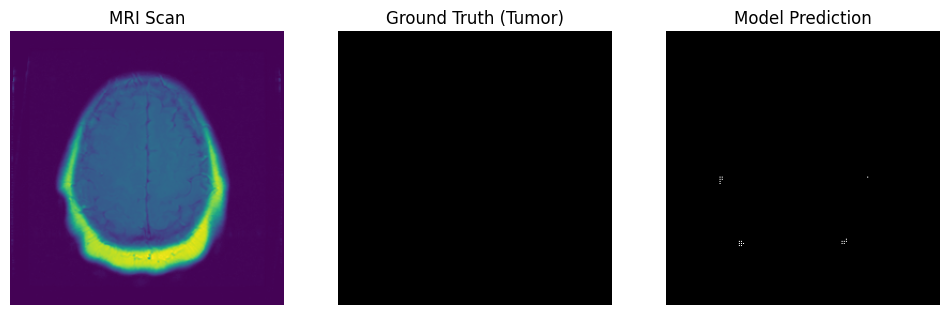

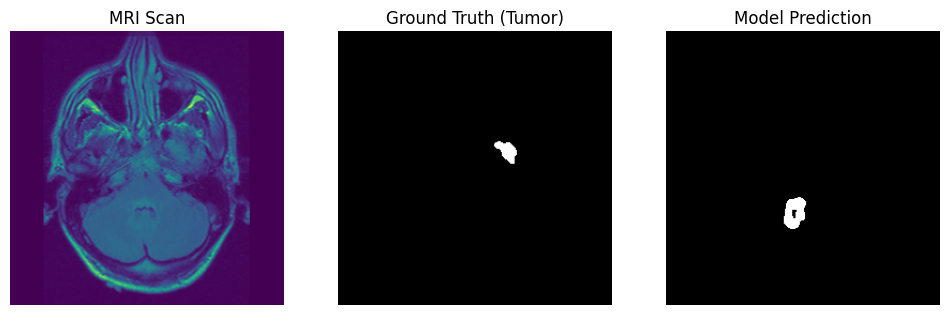

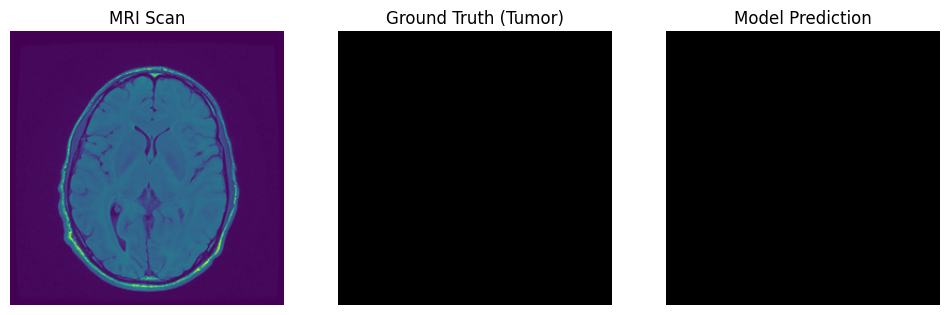

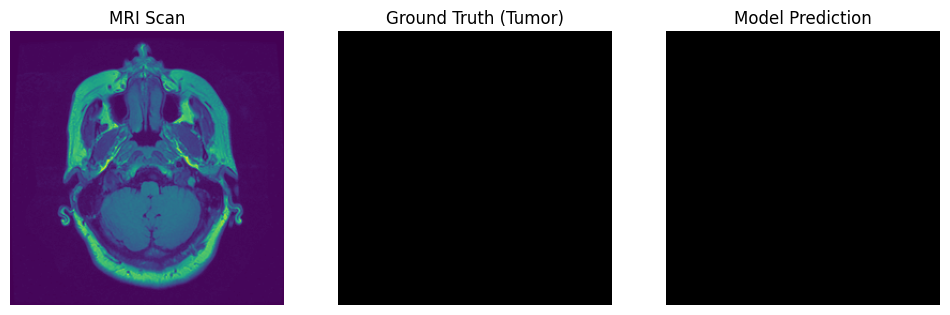

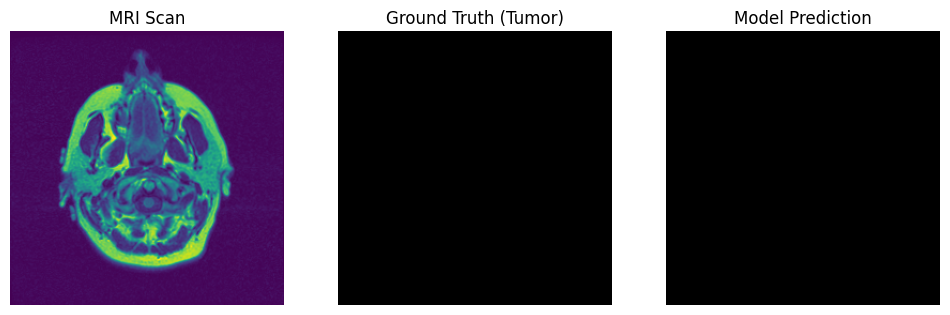

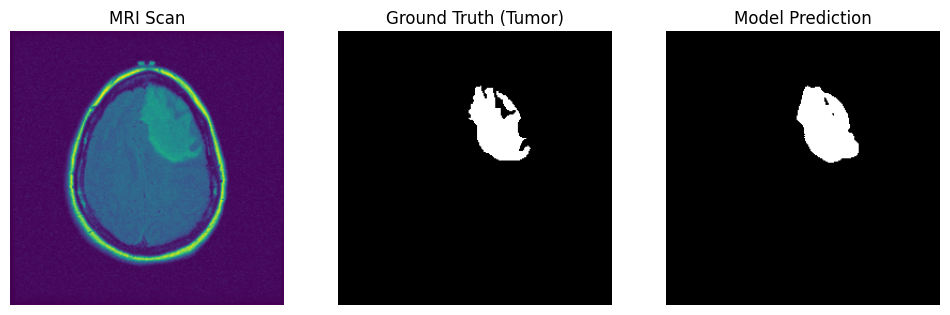

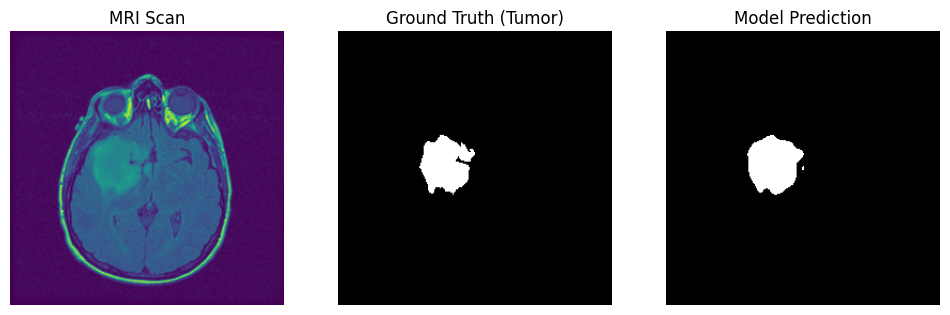

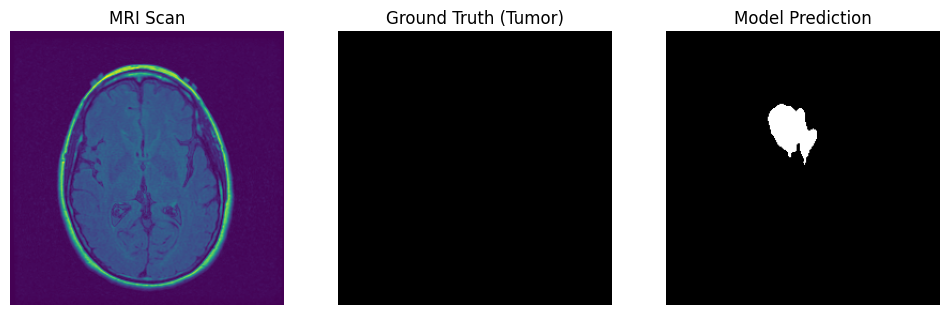

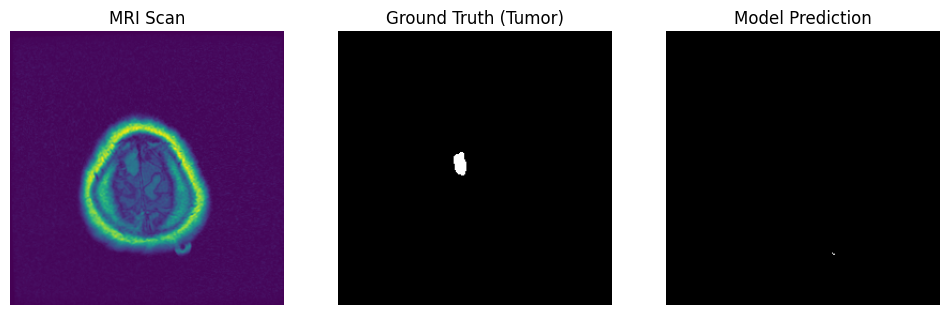

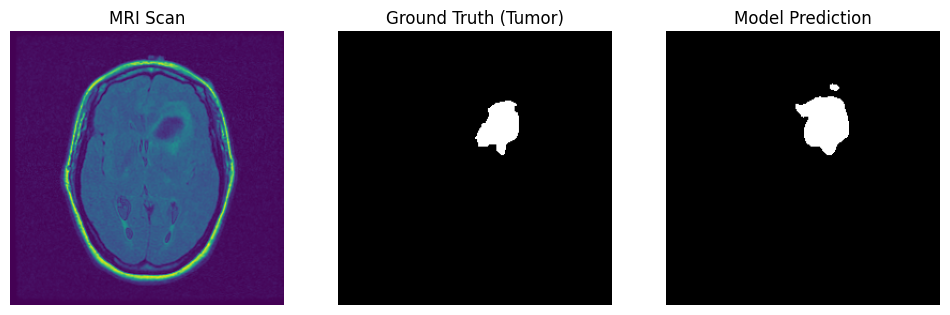

In [24]:

# 1. Clear the GPU cache from the training run
torch.cuda.empty_cache()

model.eval()
with torch.no_grad():
    # Try getting a smaller batch if 16 is too much for visualization
    images, masks = next(iter(val_loader))
    images = images.to(device)
    masks = masks.to(device)

    # Use autocast for inference too (saves memory)
    with torch.amp.autocast('cuda'):
        logits = model(images)
        preds = torch.sigmoid(logits) > 0.5

    # Move to CPU immediately to free up GPU space
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    for i in range(min(images.shape[0], 10)):  # Just show the first 5 to be safe
        img = images[i].squeeze()
        gt = masks[i].squeeze()
        pred = preds[i].squeeze()

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(img)
        axes[0].set_title("MRI Scan")
        axes[0].axis("off")

        axes[1].imshow(gt, cmap="gray")
        axes[1].set_title("Ground Truth (Tumor)")
        axes[1].axis("off")

        axes[2].imshow(pred, cmap="gray")
        axes[2].set_title(f"Model Prediction")
        axes[2].axis("off")

        plt.show()
        plt.close(fig) # CRITICAL: This prevents the 'Watchdog' from hanging

In [11]:
# Save the weights to a file
torch.save(model.state_dict(), "models/brain_tumor_model_v1.pth")
print("Model saved as brain_tumor_model_v1.pth")

Model saved as brain_tumor_model_v1.pth
